In [21]:
# !py -m pip install opencv-python
# !python.exe -m pip install --upgrade pip
import numpy as np
import cv2 as cv
from numpy import linalg
from math import acos, sqrt, degrees
from matplotlib import pyplot as plt

In [22]:
ts = []
brojac = 0
def click_event(event, x, y, flags, params): 
    global brojac
    font = cv.FONT_HERSHEY_SIMPLEX 

    if event == cv.EVENT_LBUTTONDOWN: 
        cv.putText(slika, f'P{brojac+1}(' + str(x) + ',' +
                    str(y) + ')', (x,y), font, 
                    1, (0, 0, 0), 2) 
        cv.imshow("kutija", slika)
        
        ts.append([x, y, 1])
        brojac += 1
        
        if brojac == 7:
            cv.imwrite('output_image.jpg', slika)
            cv.imshow("kutija", slika)

In [23]:
putanja = './kalibracija/kocka.png'
slika = cv.imread(putanja)

cv.imshow("kutija", slika)

cv.setMouseCallback("kutija", click_event)

cv.waitKey(0)
cv.destroyAllWindows()

In [24]:
np.array(ts)

array([[ 619,  440,    1],
       [ 929,  588,    1],
       [ 587,  762,    1],
       [ 295,  572,    1],
       [ 868,  910,    1],
       [ 597, 1112,    1],
       [ 356,  896,    1]])

In [5]:
def centar(A):
    # brisemo kolone redom i nalazimo determinante
    A1 = np.linalg.det(np.delete(A, 0, 1))
    A2 = np.linalg.det(np.delete(A, 1, 1))
    A3 = np.linalg.det(np.delete(A, 2, 1))
    A4 = np.linalg.det(np.delete(A, 3, 1))

    C = (-1/A4)*np.array([A1, -A2, A3, -A4])
    C = np.where(np.isclose(C, 0) , 0.0 , C)  # izbegavanje -0. u rezultatu
    return C

In [6]:
def kameraA(T):
    T0 = np.delete(T, 3, 1)
    if linalg.det(T0) < 0:
        T0 = -T0
    Q, R = linalg.qr(linalg.inv(T0)) 

    if R[0][0] < 0:
        R = np.diag([-1, 1, 1])@R
        Q = Q@np.diag([-1, 1, 1])
    if R[1][1] < 0:
        R = np.diag([1, -1, 1])@R
        Q = Q@np.diag([1, -1, 1])
    if R[2][2] < 0:
        R = np.diag([1, 1, -1])@R
        Q = Q@np.diag([1, 1, -1])

    A = np.transpose(Q)
    A = np.where(np.isclose(A, 0) , 0.0 , A)  # izbegavanje -0. u rezultatu
    return A


In [7]:
def kameraK(T):
    T0 = np.delete(T, 3, 1)
    if linalg.det(T0) < 0:
        T0 = -T0
    Q, R = linalg.qr(linalg.inv(T0)) 

    if R[0][0] < 0:
        R = np.diag([-1, 1, 1])@R
        Q = Q@np.diag([-1, 1, 1])
    if R[1][1] < 0:
        R = np.diag([1, -1, 1])@R
        Q = Q@np.diag([1, -1, 1])
    if R[2][2] < 0:
        R = np.diag([1, 1, -1])@R
        Q = Q@np.diag([1, 1, -1])

    K = linalg.inv(R)
    if K[2][2]:
        K = K/K[2][2]
    K = np.where(np.isclose(K, 0) , 0.0 , K)  # izbegavanje -0. u rezultatu
    return K

In [8]:
def matricaKamere(pts2D, pts3D):
    A = []
    for i in range(len(pts2D)):
        x1, x2, x3 = pts2D[i]
        xp1, xp2, xp3, xp4 = pts3D[i]
        A.append([0, 0, 0, 0, -x3*xp1, -x3*xp2, -x3*xp3, -x3*xp4, x2*xp1, x2*xp2, x2*xp3, x2*xp4])
        A.append([x3*xp1, x3*xp2, x3*xp3, x3*xp4, 0, 0, 0, 0, -x1*xp1, -x1*xp2, -x1*xp3, -x1*xp4])
    A = np.array(A)

    _, _, V = linalg.svd(A)
    T = np.array(V[-1]).reshape(3, 4)
    T /= T[2][3]
    
    T = np.where(np.isclose(T, 0) , 0.0 , T)
    return T

In [36]:
org =  np.array([1,-1,-1])*(np.array([1600,0,0])- np.array(ts))

In [37]:
# img = np.array([[0,0,3,1], [0,1,3,1], [0,2,3,1],[0,3,3,1],
#                 [1,0,3,1], [1,1,3,1], [1,2,3,1],[1,3,3,1],
#                 [2,0,3,1], [2,1,3,1], [2,2,3,1],[2,3,3,1],
#                 [3,0,3,1], [3,1,3,1], [3,2,3,1],[3,3,3,1], #gornja strana
#                 [0,3,2,1], [1,3,2,1], [2,3,2,1],[3,3,2,1],
#                 [0,3,1,1], [1,3,1,1], [2,3,1,1],[3,3,1,1],
#                 [0,3,0,1], [1,3,0,1], [2,3,0,1],[3,3,0,1], #desna
#                 [3,0,2,1],[3,1,2,1],[3,2,2,1], [3,3,2,1],
#                 [3,0,1,1],[3,1,1,1],[3,2,1,1], [3,3,1,1],
#                 [3,0,0,1],[3,1,0,1],[3,2,0,1], [3,3,0,1]])
img = np.array([[0,0,3,1],
                [0,3,3,1],
                [3,3,3,1],
                [3,0,3,1],
                [3,0,0,1],
                [3,3,0,1],
                [0,3,0,1]])

In [38]:
T = matricaKamere(org, img)
T

array([[-1.83327088e+02, -6.19498586e+01, -3.76643093e+02,
         1.00789910e+03],
       [-1.01252006e+02, -9.24217759e+01, -3.00143663e+02,
         8.74310633e+02],
       [-1.28532915e-01, -1.12867643e-01, -3.74931742e-01,
         1.00000000e+00]])

In [39]:
print('Matrica kamere:')
print(T)
print('\nPozicija centra kamere:')
C = centar(T)
print(C)
print('\nSpoljasnja matrica kamere:')
A = kameraA(T)
print(A)
print('\nMatrica kalibracije kamere:')
K = kameraK(T)
print(K)

Matrica kamere:
[[-1.83327088e+02 -6.19498586e+01 -3.76643093e+02  1.00789910e+03]
 [-1.01252006e+02 -9.24217759e+01 -3.00143663e+02  8.74310633e+02]
 [-1.28532915e-01 -1.12867643e-01 -3.74931742e-01  1.00000000e+00]]

Pozicija centra kamere:
[137.5858551  144.94303689 -88.13254869   1.        ]

Spoljasnja matrica kamere:
[[ 0.71260137  0.56591728 -0.41465276]
 [-0.62842934  0.77764279 -0.01866167]
 [ 0.31189077  0.27387829  0.90978834]]

Matrica kalibracije kamere:
[[ 2.31044164e+01 -1.79714819e+02  1.01140837e+03]
 [ 0.00000000e+00  6.40659485e+00  8.00660229e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


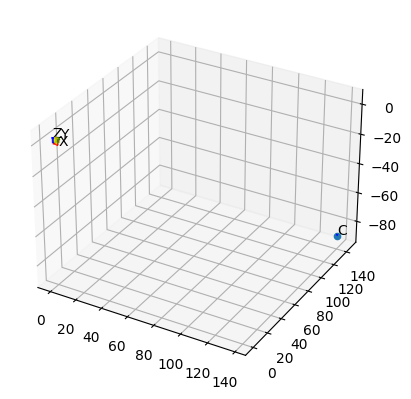

In [40]:
n_voxels = np.zeros((3, 3, 3), dtype=bool)
for i in range(3):
    for j in range(3):
        for k in range(3):
            if (i+j+k)%2 == 1:
                n_voxels[i,j,k] = True
filled = np.ones(n_voxels.shape)
ax = plt.figure().add_subplot(projection='3d')
facecolors = np.where(n_voxels, 'red', 'yellow')
ax.voxels(filled, facecolors=facecolors)

ax.quiver(0,0,0, 4,0,0, color='red', label='x', alpha=0.9)
ax.text(4.2, 0, 0, s="X")
ax.quiver(0,0,0, 0,4,0, color='green', label='y', alpha=0.9)
ax.text(0, 4.2, 0, s="Y")
ax.quiver(0,0,0, 0,0,4, color='blue', label='z', alpha=0.9)
ax.text(0, 0, 4.2, s="Z")

ax.quiver(C[0], C[1], C[2], A[0][0], A[0][1], A[0][2], color='red', label='x', alpha=0.9)
ax.quiver(C[0], C[1], C[2], A[1][0], A[1][1], A[1][2], color='green', label='y', alpha=0.9)
ax.quiver(C[0], C[1], C[2], A[2][0], A[2][1], A[2][2], color='blue', label='z', alpha=0.9)
ax.scatter(C[0], C[1], C[2])
ax.text(C[0]+0.2, C[1]+0.2, C[2]+0.2, s="C")

d =  (7.6/35)*26

plt.show()

In [6]:
def afinize(tacka):
    return list(map(lambda x : x / tacka[2], tacka))[:-1]

In [7]:
def cross(x, y):
    return np.cross(x, y)

In [8]:
def tacka_nedogleda(t1, t2, t3, t4):
    return list(cross(cross(t1, t2), cross(t3, t4)))

In [9]:
def zaokruzi(tacka):
    return list(map(lambda x : round(x), tacka))

In [15]:

# def homogenize(lista_tacaka):
#     for tacka in lista_tacaka:
#         tacka = tacka.append(1)
#     return lista_tacaka

def osmoteme(lista_tacaka):
    #pretvori u homogene
#     lista_tacaka = homogenize(lista_tacaka)
    #izracunaj_tacku
    t1, t2, t3, t5, t6, t7, t8 = lista_tacaka
    
    xb = tacka_nedogleda(t2, t6, t1, t5)
    yb = tacka_nedogleda(t5, t6, t7, t8)
    return afinize(tacka_nedogleda(t8, xb, t3, yb))

In [19]:
ts

[[658, 474, 1],
 [399, 544, 1],
 [379, 989, 1],
 [587, 903, 1],
 [272, 264, 1],
 [106, 285, 1],
 [135, 604, 1]]

In [18]:
osmoteme(ts)

[-2.548355038387823, -1.7282233739437833]

In [31]:
t1, t2, t3, t5, t6, t7, t8 = ts
    
xb = zaokruzi(tacka_nedogleda(t2, t6, t1, t5))
xb

[-44504760, -72028920, -77434]

In [32]:
yb = zaokruzi(tacka_nedogleda(t5, t6, t7, t8))
yb

[-5525988, 13728065, -82069]

In [ ]:
tacka_nedogleda(t8, xb, t3, yb)

In [17]:
def osmoteme(ts):
    return [268, 563]